# Predictive Maintenance

The company provides telemetry attributes that are used to helped determine the condition of a device and predict when a maintenance should be performed.  This approach promises cost savings over routine or time-based preventive  maintenance, because tasks are performed only when warranted.

## Overview

- Apply sampling methods to an imbalanced dataset
- Create in-depth data exploratory analysis to understand features 
- Minimize false negatives and false positives as much as possible
- Cross validate with random forest and ensemble

### Loading Data

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
df = pd.read_csv('failures.csv')

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


## Exploratory Data Analysis

In [4]:
# No missing values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [5]:
# 106 total failures 
df['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [6]:
# 1168 unique devices
len(df['device'].unique())

1168

In [7]:
# df.profile_report(style={'full_width':True})

### Summary

- The dataset is clean, and there are no missing values. All values are integer type.
- The dataset is imbalanced, about 0.1% of the classes are failures. We will need to be deal with this problem by either upsample or downsample.
- The sparse number of distinctive values most likely represents a categorical variable. These attributes are attribute 3, 5, 7, 9, which I will encode for modeling. 
- Attribute 7 and 8 are the same, so we will drop one of the columns.
- Attribute 2, 3, 4, 5, 7, 9 are highly skewed. We will need to apply transformations. I therefore applied a log +1p transformation to unskew.
- The magnitudes differ by a wide margin. Therefore scaling needs to be done. I used min max scaler to normalize the feature from range 0 to 1 and keep the outliers.

## Date Exploration

### create features based on date

In [8]:
df.date = pd.to_datetime(df.date)

In [9]:
df['activedays']=df.date-df.date[0]

In [10]:
df['month']=df['date'].dt.month

In [11]:
df.tail()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,305 days,11
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,305 days,11
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,305 days,11
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,305 days,11
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0,305 days,11


In [12]:
df.groupby('month').agg({'device':lambda x: x.nunique()})

,device
month,
1,1164
2,726
3,685
4,491
5,424
6,352
7,346
8,334
9,184


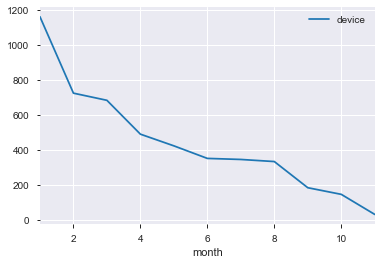

In [13]:
df.groupby('month').agg({'device':lambda x: x.nunique()}).plot()

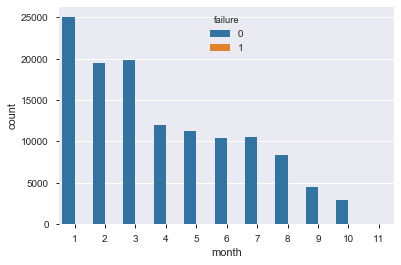

In [14]:
ax = sns.countplot(x="month", hue="failure", data=df)


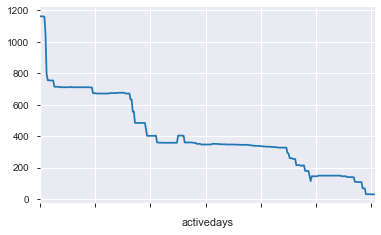

In [15]:
df.groupby('activedays')['device'].count().plot()


### Failed Devices that are reused

There are devices that have failed but are reused. We group devices by the maximum date to

In [16]:
df_date = df.groupby('device').agg({'date':max})
df_date.date.to_dict()

{'S1F01085': Timestamp('2015-01-06 00:00:00'),
 'S1F013BB': Timestamp('2015-05-11 00:00:00'),
 'S1F0166B': Timestamp('2015-01-06 00:00:00'),
 'S1F01E6Y': Timestamp('2015-02-17 00:00:00'),
 'S1F01JE0': Timestamp('2015-01-06 00:00:00'),
 'S1F01R2B': Timestamp('2015-08-24 00:00:00'),
 'S1F01TD5': Timestamp('2015-01-06 00:00:00'),
 'S1F01XDJ': Timestamp('2015-04-16 00:00:00'),
 'S1F023H2': Timestamp('2015-01-19 00:00:00'),
 'S1F02A0J': Timestamp('2015-08-28 00:00:00'),
 'S1F02DZ2': Timestamp('2015-01-06 00:00:00'),
 'S1F02EVN': Timestamp('2015-01-06 00:00:00'),
 'S1F02L38': Timestamp('2015-03-27 00:00:00'),
 'S1F02MGA': Timestamp('2015-01-06 00:00:00'),
 'S1F02P76': Timestamp('2015-01-06 00:00:00'),
 'S1F02VAX': Timestamp('2015-01-06 00:00:00'),
 'S1F02W1L': Timestamp('2015-05-11 00:00:00'),
 'S1F02WFT': Timestamp('2015-01-06 00:00:00'),
 'S1F02XLX': Timestamp('2015-05-11 00:00:00'),
 'S1F0318A': Timestamp('2015-01-06 00:00:00'),
 'S1F0322R': Timestamp('2015-01-06 00:00:00'),
 'S1F0330P': 

In [17]:
df_date.head()

,date
device,
S1F01085,2015-01-06
S1F013BB,2015-05-11
S1F0166B,2015-01-06
S1F01E6Y,2015-02-17
S1F01JE0,2015-01-06


In [18]:
df_failure = df.loc[df.failure==1,['device','date']]
df_good = df.loc[df.failure==0,['device','date']]

In [19]:
df_failure

,device,date
4885,S1F0RRB1,2015-01-05
6879,S1F0CTDN,2015-01-07
8823,W1F0PNA5,2015-01-09
11957,W1F13SRV,2015-01-13
12668,W1F1230J,2015-01-14
...,...,...
109927,W1F1CB5E,2015-08-04
114251,Z1F0MRPJ,2015-08-18
122118,S1F0JGJV,2015-10-05
122808,Z1F14BGY,2015-10-09


In [20]:
df_good

,device,date
0,S1F01085,2015-01-01
1,S1F0166B,2015-01-01
2,S1F01E6Y,2015-01-01
3,S1F01JE0,2015-01-01
4,S1F01R2B,2015-01-01
...,...,...
124489,Z1F0MA1S,2015-11-02
124490,Z1F0Q8RT,2015-11-02
124491,Z1F0QK05,2015-11-02
124492,Z1F0QL3N,2015-11-02


In [21]:
df_date.shape,df_failure.shape

((1168, 1), (106, 2))

In [22]:
df['max_date']=df.device.map(df_date.date.to_dict())

In [23]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,max_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,0 days,1,2015-01-06
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,0 days,1,2015-01-06
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,0 days,1,2015-02-17
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,0 days,1,2015-01-06
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,0 days,1,2015-08-24


In [24]:
dff=df[(df.failure==1)&(df.date!=df.max_date)]
dff

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,max_date
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,124 days,5,2015-05-06
79590,2015-05-09,W1F0KCP2,1,176861128,10392,0,121,6,310699,0,0,0,128 days,5,2015-05-11
79601,2015-05-09,W1F0M35B,1,141805096,0,0,1,7,267203,0,0,0,128 days,5,2015-05-11
101999,2015-07-12,S1F0GPFZ,1,236544080,0,0,0,9,264594,0,0,0,192 days,7,2015-07-24
104223,2015-07-18,W1F11ZG9,1,32671632,368,9,486,3,344433,0,0,1,198 days,7,2015-08-17


In [25]:
df[df['device'] == 'S1F136J0']

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,max_date
500,2015-01-01,S1F136J0,0,229928576,0,0,25,16,312312,0,0,0,0 days,1,2015-05-06
1663,2015-01-02,S1F136J0,0,6051808,0,0,25,16,313710,0,0,0,1 days,1,2015-05-06
2826,2015-01-03,S1F136J0,0,29281832,0,0,25,16,315035,0,0,0,2 days,1,2015-05-06
3989,2015-01-04,S1F136J0,0,54942936,0,0,25,16,316364,0,0,0,3 days,1,2015-05-06
5150,2015-01-05,S1F136J0,0,73810232,0,0,25,16,317707,0,0,0,4 days,1,2015-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76881,2015-05-02,S1F136J0,0,55535800,0,0,25,16,340161,8,8,0,121 days,5,2015-05-06
77240,2015-05-03,S1F136J0,0,72745992,0,0,25,16,341416,8,8,0,122 days,5,2015-05-06
77599,2015-05-04,S1F136J0,0,81808304,0,0,25,16,342707,8,8,0,123 days,5,2015-05-06
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,124 days,5,2015-05-06


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

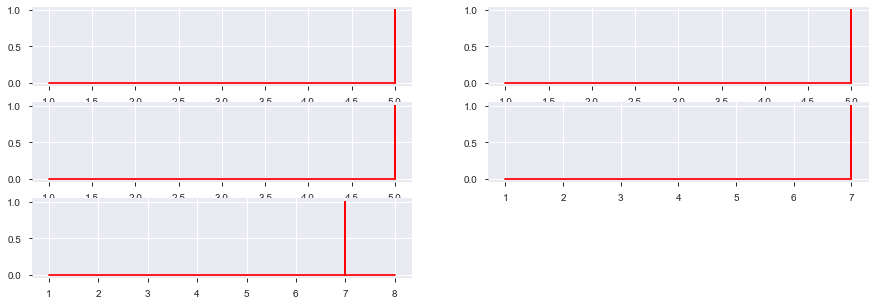

In [27]:

fig = plt.figure(figsize=(15,5))
fig.add_subplot(3, 2, 1) 
plt.plot(df.loc[df['device']=='S1F136J0',['failure','month']]['month'],df.loc[df['device']=='S1F136J0',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 2) 
plt.plot(df.loc[df['device']=='W1F0KCP2',['failure','month']]['month'],df.loc[df['device']=='W1F0KCP2',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 3)
plt.plot(df.loc[df['device']=='W1F0M35B',['failure','month']]['month'],df.loc[df['device']=='W1F0M35B',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 4)
plt.plot(df.loc[df['device']=='S1F0GPFZ',['failure','month']]['month'],df.loc[df['device']=='S1F0GPFZ',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 5)
plt.plot(df.loc[df['device']=='W1F11ZG9',['failure','month']]['month'],df.loc[df['device']=='W1F11ZG9',\
         ['failure','month']]['failure'],\
         color = 'red')

plt.show()

### Group by Device

In [28]:
df1 = df.groupby('device').agg({'date':max})

In [29]:
df1.head()

,date
device,
S1F01085,2015-01-06
S1F013BB,2015-05-11
S1F0166B,2015-01-06
S1F01E6Y,2015-02-17
S1F01JE0,2015-01-06


In [30]:
df1=df1.reset_index()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 2 columns):
device    1168 non-null object
date      1168 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 18.4+ KB


In [31]:


df =df.reset_index(drop =True)

df2 = pd.merge(df1,df,how='left', on = ['device','date'])

df2.shape

(1168, 15)

In [32]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,max_date
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,5 days,1,2015-01-06
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,130 days,5,2015-05-11
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,5 days,1,2015-01-06
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,47 days,2,2015-02-17
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,5 days,1,2015-01-06


### Create feature called 'failure_before'

In [33]:
df2['failure_before']=0

In [34]:
df2.loc[df2.device == 'S1F136J0','failure_before'] = 1
df2.loc[df2.device == 'W1F0KCP2','failure_before'] = 1
df2.loc[df2.device == 'W1F0M35B','failure_before'] = 1
df2.loc[df2.device == 'S1F0GPFZ','failure_before'] = 1
df2.loc[df2.device == 'W1F11ZG9','failure_before'] = 1

In [35]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,max_date,failure_before
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,5 days,1,2015-01-06,0
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,130 days,5,2015-05-11,0
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,5 days,1,2015-01-06,0
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,47 days,2,2015-02-17,0
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,5 days,1,2015-01-06,0


### Create device_class feature 

In [36]:
# Create a commonn device column
# The first four characters of a device represents the brand of device
df2['device_class'] = df2.device.apply(lambda x: x[:4])

In [37]:
dev=pd.crosstab(df2['device_class'],df2['failure'])

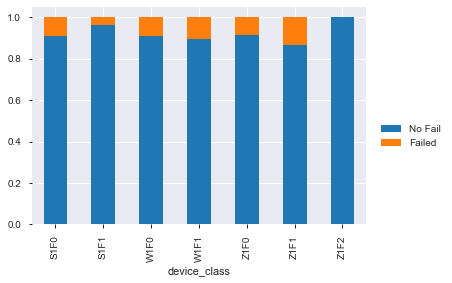

In [38]:

dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True).legend(["No Fail", "Failed"], bbox_to_anchor=(1.25, 0.5))

In [39]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,max_date,failure_before,device_class
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,0,7,5 days,1,2015-01-06,0,S1F0
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,0,130 days,5,2015-05-11,0,S1F0
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,0,5 days,1,2015-01-06,0,S1F0
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,0,47 days,2,2015-02-17,0,S1F0
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,0,5 days,1,2015-01-06,0,S1F0


## Preprocessing Structured Data

In [40]:
# Drop attribute8 column because it is a duplicate of attribute7
df2 =df2.drop(columns = ['attribute8'])

In [41]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,activedays,month,max_date,failure_before,device_class
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,7,5 days,1,2015-01-06,0,S1F0
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,130 days,5,2015-05-11,0,S1F0
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,5 days,1,2015-01-06,0,S1F0
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,47 days,2,2015-02-17,0,S1F0
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,5 days,1,2015-01-06,0,S1F0


In [42]:
#make classification and continous variables
cat_columns = ['attribute3','attribute5','attribute7','attribute9','activedays']
df2[cat_columns]= df2[cat_columns].astype(str)

In [43]:
df2['activedays']= df2['activedays'].apply( lambda x: int(x.split(' ')[0]))

In [44]:
df2.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,activedays,month,max_date,failure_before,device_class
0,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,7,5,1,2015-01-06,0,S1F0
1,S1F013BB,2015-05-11,0,115676688,0,0,0,5,689161,0,0,130,5,2015-05-11,0,S1F0
2,S1F0166B,2015-01-06,0,7441792,0,3,0,6,404786,0,0,5,1,2015-01-06,0,S1F0
3,S1F01E6Y,2015-02-17,0,147350000,0,0,0,12,259491,0,0,47,2,2015-02-17,0,S1F0
4,S1F01JE0,2015-01-06,0,185424928,0,0,0,6,412151,0,0,5,1,2015-01-06,0,S1F0


In [45]:
df2.drop(['date','max_date'],axis=1,inplace=True)

In [46]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 14 columns):
device            1168 non-null object
failure           1168 non-null int64
attribute1        1168 non-null int64
attribute2        1168 non-null int64
attribute3        1168 non-null object
attribute4        1168 non-null int64
attribute5        1168 non-null object
attribute6        1168 non-null int64
attribute7        1168 non-null object
attribute9        1168 non-null object
activedays        1168 non-null int64
month             1168 non-null int64
failure_before    1168 non-null int64
device_class      1168 non-null object
dtypes: int64(8), object(6)
memory usage: 136.9+ KB


In [47]:
df2.corr()

,failure,attribute1,attribute2,attribute4,attribute6,activedays,month,failure_before
failure,1.000000,0.018729,0.171187,0.160769,-0.042033,-0.022064,-0.030503,-0.020173
attribute1,0.018729,1.000000,-0.030013,0.009994,-0.055800,-0.031700,-0.031810,0.035230
attribute2,0.171187,-0.030013,1.000000,0.349730,-0.026274,-0.030174,-0.029863,0.015714
attribute4,0.160769,0.009994,0.349730,1.000000,0.001997,-0.055892,-0.054880,0.105300
attribute6,-0.042033,-0.055800,-0.026274,0.001997,1.000000,0.198553,0.211401,0.024530
activedays,-0.022064,-0.031700,-0.030174,-0.055892,0.198553,1.000000,0.997190,0.032458
month,-0.030503,-0.031810,-0.029863,-0.054880,0.211401,0.997190,1.000000,0.033250
failure_before,-0.020173,0.035230,0.015714,0.105300,0.024530,0.032458,0.033250,1.000000


### Data Transformation

We must do a numerical transformation

Text(0.5, 1.0, 'Log-Transformed Distribution')

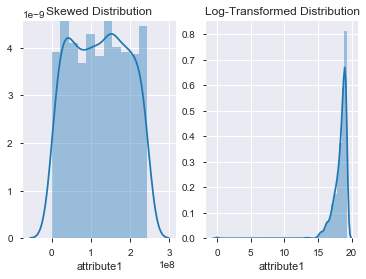

In [48]:
f, axarr = plt.subplots(1,2)
sns.distplot(df2['attribute1'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df2['attribute1']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

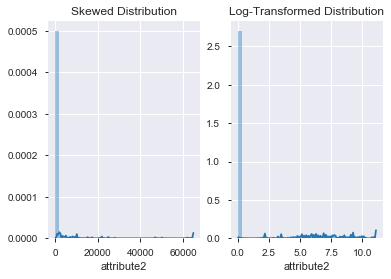

In [49]:
f, axarr = plt.subplots(1,2)
sns.distplot(df2['attribute2'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df2['attribute2']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

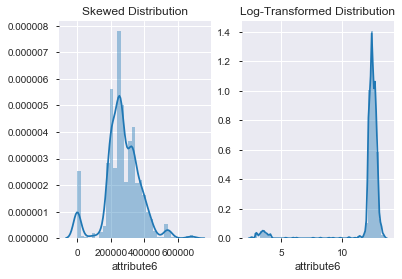

In [50]:
f, axarr = plt.subplots(1,2)
sns.distplot(df2['attribute6'],ax=axarr[0])
axarr[0].set_title('Skewed Distribution')
sns.distplot(np.log(1+df2['attribute6']),ax=axarr[1])
axarr[1].set_title('Log-Transformed Distribution')

In [51]:
from sklearn import preprocessing
#scaling
# Create scaler
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

# transformation = ['attribute1','attribute2', 'attribute6']

# df2[transformation] = minmax_scale.fit_transformform(df2[transformation])


# Scale feature
df2['attribute1'] = minmax_scale.fit_transform(df2['attribute1'].values.reshape(-1,1))
df2['attribute2'] = minmax_scale.fit_transform(df2['attribute2'].values.reshape(-1,1))
df2['attribute6'] = minmax_scale.fit_transform(df2['attribute6'].values.reshape(-1,1))


In [52]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# #numerical features standardization
# num_ftrs =['attribute1','attribute2','attribute6'] 
# df2[num_ftrs]=scaler.fit_transform(df2[num_ftrs])

# df2.info()

In [53]:
df2 = pd.get_dummies(df2, drop_first = True)
y= df2['failure']
result =df2.drop(columns = ['failure'])

In [54]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=50, max_features='auto')
# clf= clf.fit(result,y)

# features = pd.DataFrame()
# features['feature']= result.columns
# features['important']=clf.feature_importances_
# features.sort_values(by=['important'], ascending=False,inplace=True)
# features.set_index('feature', inplace=True)
# features.iloc[:20,:].plot(kind='barh', figsize=(30,30))

In [55]:
# from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(clf,prefit=True)
# x_reduced = model.transform(result)
# print (x_reduced.shape)

In [56]:
# x_reduced=pd.DataFrame(x_reduced)

In [57]:
# x_reduced.head()

## Modeling

In [58]:
#import models
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.25, random_state=42)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((876, 1363), (292, 1363), (876,), (292,))

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

# from imblearn import under_sampling 
# from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

#parameters for tDMassess function
g = GaussianNB()
b = BernoulliNB()
k = KNeighborsClassifier()
log = LogisticRegression()
gbc = GradientBoostingClassifier()
r = RandomForestClassifier()
# r = RandomForestClassifier(n_estimators=5000, random_state=21)
xgb = XGBClassifier()
svc = SVC()
algorithms = [g, b, k, log, gbc, r, xgb, svc]
names = ['GaussianNB', 'BernoulliNB', 'K Nearest', 'Logistic', 'Gradient Boosting', 'Random Forest', 'XG Boost', 'SVC']

### Oversample within Cross-Validation

In [62]:
def kfoldAssessROS(X_train, y_train, algorithms, names ):
    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()
    Accuracy = []
    Precision= []
    Recall= []
    F1 = []
    #fit the data
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=69,shuffle=True)
        accuracy = []
        precision= []
        recall= []
        f1 = []
        for train_index,test_index in kf.split(X_train,y_train):
#             print('\n{} of kfold {}'.format(j,kf.n_splits))
            xtrain, xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest= y_train[train_index],y_train[test_index]
            xtrain_resample,ytrain_resample=ros.fit_sample(xtrain, ytrain)
            fit= algorithms[i].fit(xtrain_resample,ytrain_resample)
            y_pred_test = fit.predict(xtest)
            
            accuracy.append(accuracy_score(ytest,y_pred_test))
            precision.append(precision_score(ytest,y_pred_test))
            recall.append(recall_score(ytest,y_pred_test))
            f1.append(f1_score(ytest,y_pred_test))
            j+=1
        mean_accuracy = np.mean(accuracy)
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        mean_f1 = np.mean(f1)
        Accuracy.append(mean_accuracy)
        Precision.append(mean_precision)
        Recall.append(mean_recall)
        F1.append(mean_f1)
        
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'], index = names)
    metrics['Accuracy'] =Accuracy
    metrics['Precision'] = Precision
    metrics['Recall']=Recall
    metrics['F1']=F1
    return metrics.sort_values('F1',ascending = False)

In [63]:
kfoldAssessROS(X_train, y_train, algorithms, names )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

,Accuracy,Precision,Recall,F1
XG Boost,0.958935,0.753132,0.806667,0.775993
K Nearest,0.950921,0.714886,0.729167,0.718039
Gradient Boosting,0.944090,0.657056,0.740000,0.693983
SVC,0.889349,0.439443,0.834167,0.574620
BernoulliNB,0.867635,0.371774,0.661667,0.473357
Random Forest,0.930389,0.765556,0.325000,0.452677
Logistic,0.898434,0.407381,0.299167,0.336912
GaussianNB,0.255731,0.089894,0.816667,0.161947


- precision is masurement of relevant results
- recall is a measure of how many truly relevant results are returned
- specificity
- f1 is the harmonic mean of precision and recall
- Matthews correlation coefficient is the geometric mean of specificity and sensitivity
- iba is the index of imbalanced accuracy